In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from src.data.dataset_blond import BLOND
from src.features.features import *

%load_ext autoreload
%autoreload 2

In [ ]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
batch_size = 48
class_dict = {
    'Battery Charger': 0,
    'Daylight': 1,
    'Dev Board': 2,
    'PC': 3,
    'Printer': 4,
    'Projector': 5,
    'Screen Motor': 6,
    'USB Charger': 7
}

dataset = BLOND('all', '../data/', class_dict=class_dict, transform=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_classes = len(dataset.class_dict.keys())
print(len(dataset))

In [ ]:
max = 0
min = 0
for i, (real, _, _) in enumerate(dataloader, 0):
    tmp_max = torch.max(real)
    tmp_min = torch.min(real)
    if max < tmp_max:
        max = tmp_max
    if min > tmp_min:
        min = tmp_min
print(f'Max value: {max}')
print(f'Min value: {min}')

In [ ]:
def normalize(x, max=max, min=min):

    return 2 * (x - min)/(max - min) - 1

def denormalize(x, max=max, min=min):

    return 0.5 * (x*max - x*min + max + min)

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=None):
        super(DenseBlock, self).__init__()
        if activation == 'sig':
            self.activation = nn.Sigmoid()
        if activation == 'softmax':
            self.activation = nn.Softmax()
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()

        self.bn = nn.BatchNorm1d(in_channels)

        self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv1d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv1d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv1d(in_channels = 128, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x):
        bn = self.bn(x)
        conv1 = self.activation(self.conv1(bn))
        conv2 = self.activation(self.conv2(conv1))

        c2_dense = self.activation(torch.cat([conv1, conv2], 1))
        conv3 = self.activation(self.conv3(c2_dense))
        c3_dense = self.activation(torch.cat([conv1, conv2, conv3], 1))
        conv4 = self.activation(self.conv4(c3_dense))
        c4_dense = self.activation(torch.cat([conv1, conv2, conv3, conv4], 1))

        conv5 = self.activation(self.conv5(c4_dense))
        c5_dense = self.activation(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

        return c5_dense

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 10, kernel_size=7, stride=3, padding=0),
            nn.BatchNorm1d(10),
            nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(10, 20, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm1d(20),
            nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(20, 30, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(30),
            nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(30, 40, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm1d(40),
            nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(40, 50, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(50),
            nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            DenseBlock(50, 1, 'relu')
        )
        self.linear = nn.Linear(903, 1)

    def forward(self, x):
        x = self.model(x)
        x = x.reshape(x.size(0), -1)
        #print(x.shape)
        x = self.linear(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 10, kernel_size=7, stride=3, padding=1),
            nn.BatchNorm1d(10),
            #nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(10, 20, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(20),
            #nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(20, 30, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(30),
            #nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(30, 40, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(40),
            #nn.MaxPool1d(kernel_size=3),
            nn.ReLU(),

            nn.ConvTranspose1d(40, 30, kernel_size=7, stride=3, padding=2),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.ConvTranspose1d(30, 20, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.ConvTranspose1d(20, 10, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.ConvTranspose1d(10, 5, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm1d(5),
            #-nn.ReLU(),
            nn.ConvTranspose1d(5, 1, kernel_size=3, stride=1, padding=1),
            #-nn.ReLU(),
        )

    def forward(self, x):
        x = self.model(x)
        #x = x.reshape(x.size(0), -1)
        return x

G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
lr = 1e-3
std = 0.1

G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
G_scheduler = StepLR(G_solver, 300, 0.1)
D_scheduler = StepLR(D_solver, 300, 0.1)
mse_loss = nn.MSELoss()

"""
https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_pytorch.py
"""
for it in range(1000):
    for _ in range(5):
        # Sample data
        x, _, _ = next(iter(dataloader))
        noise = x.data.new(x.size()).normal_(0, std)
        x += noise
        x = x.to(device)
        x = x.unsqueeze(1)

        # Dicriminator forward-loss-backward-update
        G_sample = G(x)
        D_real = D(x)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        G.zero_grad()
        D.zero_grad()

    # Generator forward-loss-backward-update
    x, _, _ = next(iter(dataloader))
    noise = x.data.new(x.size()).normal_(0, std)
    x += noise
    x = x.to(device)
    x = x.unsqueeze(1)

    G_sample = G(x)
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)
    G_mse = mse_loss(G_sample, x)
    G_loss = G_loss + 2 * G_mse

    G_loss.backward()
    G_solver.step()

    G.zero_grad()
    D.zero_grad()

    G_scheduler.step()
    D_scheduler.step()


    if it % 10 == 0:
        print(f'Iteration{it}; D_loss: {D_loss}; G_loss: {G_loss}')


In [25]:
#torch.save(G.state_dict(), f"generator_model.pth")
G.load_state_dict(torch.load('generator_model.pth'))

<All keys matched successfully>

In [27]:
x, v, c = next(iter(dataloader))
x = x.unsqueeze(1)
noise = x.data.new(x.size()).normal_(0, std)
Z = (x + noise).to(device)
x = x.to(device)


generated_X = G(Z).detach().cpu().squeeze()

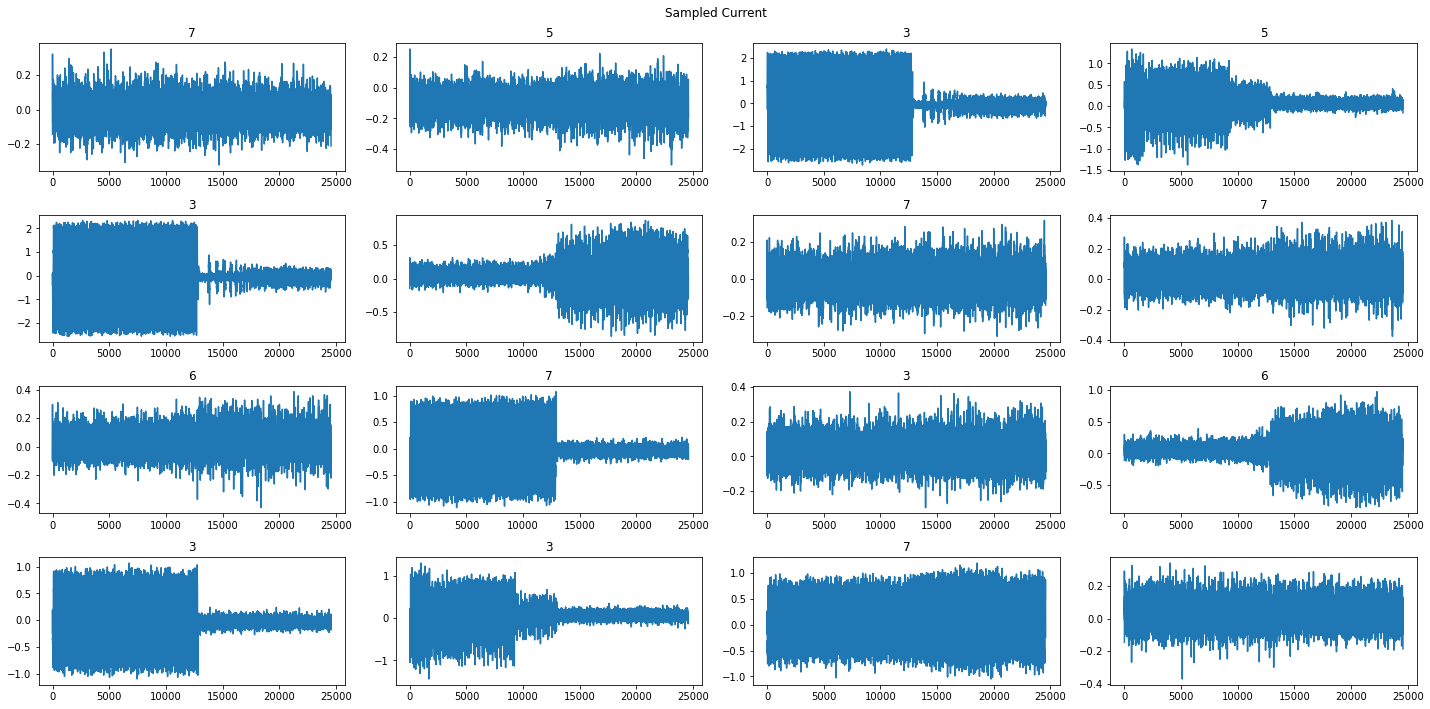

In [28]:
plt.figure(figsize=(20, 10))
plt.suptitle(f'Sampled Current')
for i in range(16):
    plt.title(c[i].item())
    ax = plt.subplot(4, 4, i + 1)
    plt.plot(generated_X[i])

plt.tight_layout()
plt.show()
x = x.cpu().squeeze()

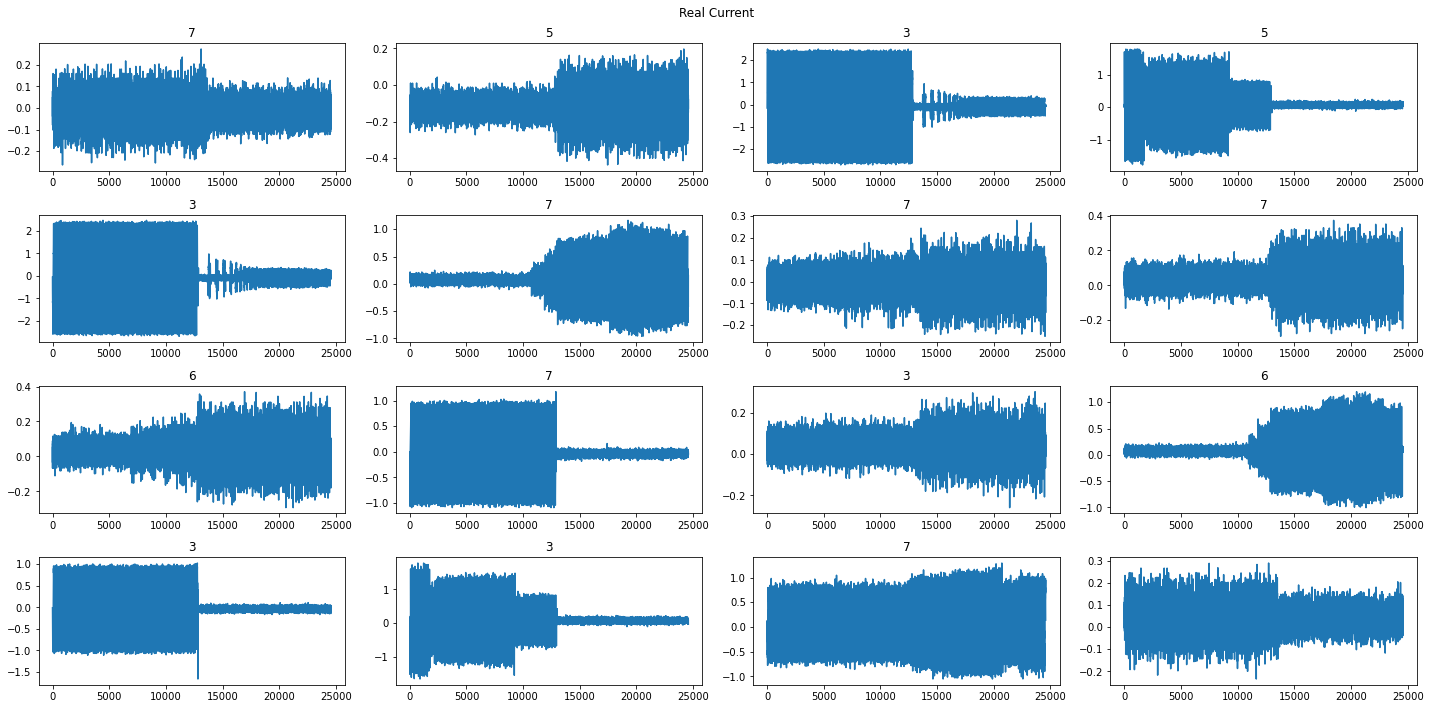

In [29]:
plt.figure(figsize=(20, 10))
plt.suptitle(f'Real Current')
for i in range(16):
    plt.title(c[i].item())
    ax = plt.subplot(4, 4, i + 1)
    plt.plot(x[i])

plt.tight_layout()
plt.show()

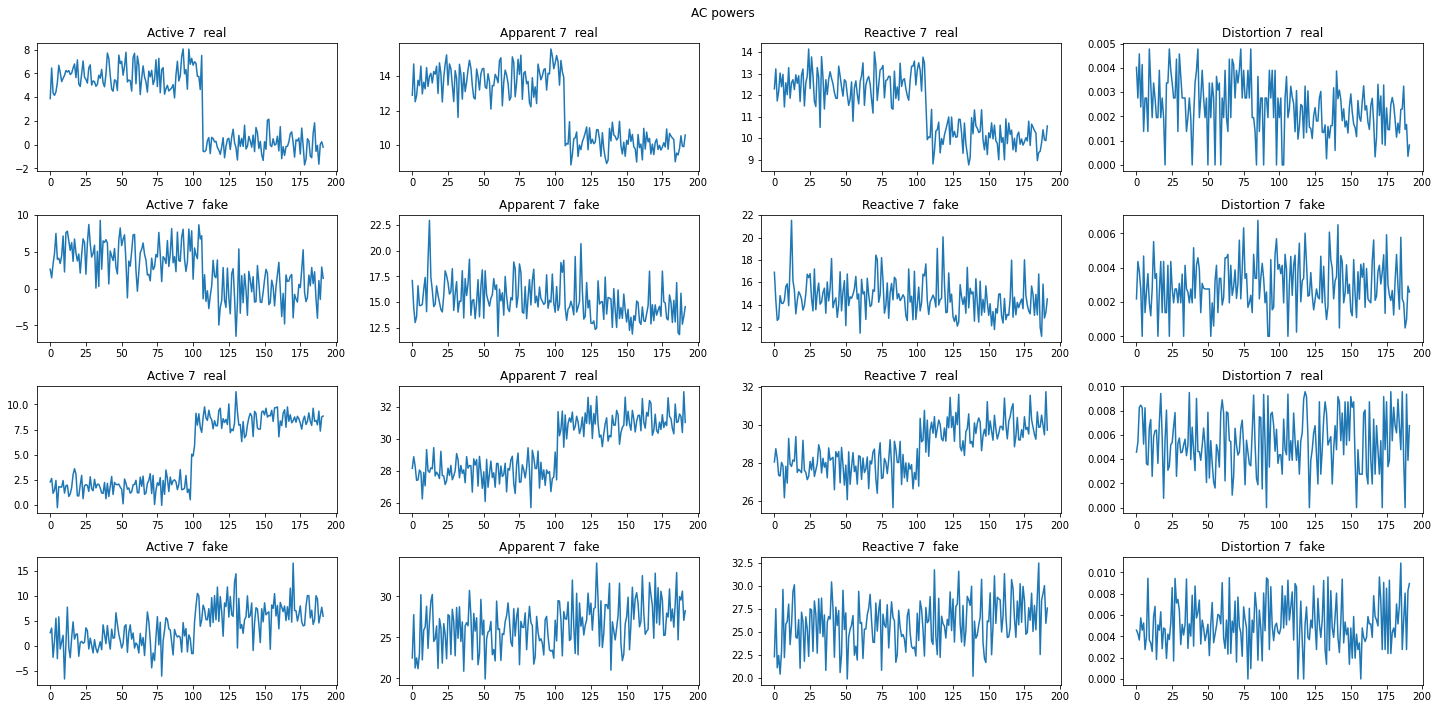

In [30]:
x = x.cpu().squeeze()
ac = ACPower(measurement_frequency=6400)

plt.figure(figsize=(20, 10))
plt.suptitle(f'AC powers')

j = 0
k = 0
for i in range(0, 4):

    if i % 2 == 0:
        sample = x[k], v[k], c[k]
        sub = ' real'
        k += 1
    else:
        sample = generated_X[j], v[j], c[j]
        sub = ' fake'
        j += 1

    _, _, features, class_nr = ac((sample[0], sample[1], None, sample[2]))

    plt.subplot(4, 4, i*4+1)
    plt.plot(features[0])
    plt.title(f'Active {sample[2]} {sub}')

    plt.subplot(4, 4, i*4+2)
    plt.plot(features[1])
    plt.title(f'Apparent {sample[2]} {sub}')

    plt.subplot(4, 4, i*4+3)
    plt.plot(features[2])
    plt.title(f'Reactive {sample[2]} {sub}')

    plt.subplot(4, 4, i*4+4)
    plt.plot(features[3])
    plt.title(f'Distortion {sample[2]} {sub}')

plt.tight_layout()
plt.show()

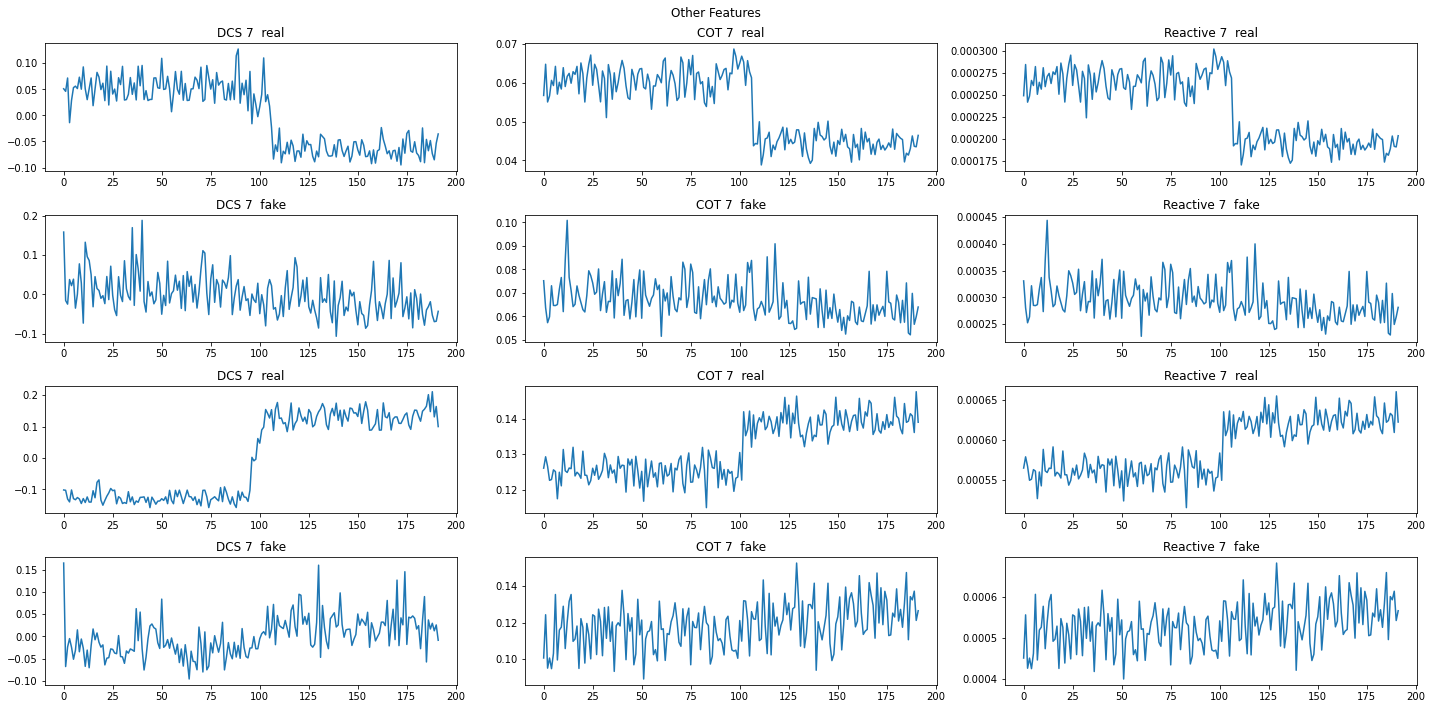

In [31]:
x = x.cpu().squeeze()
dcs = DCS(measurement_frequency=6400)
cot = COT(measurement_frequency=6400)
aot = AOT(measurement_frequency=6400)

plt.figure(figsize=(20, 10))
plt.suptitle(f'Other Features')

j = 0
k = 0
for i in range(0, 4):

    if i % 2 == 0:
        sample = x[k], v[k], c[k]
        sub = ' real'
        k += 1
    else:
        sample = generated_X[j], v[j], c[j]
        sub = ' fake'
        j += 1

    _, _, features, class_nr = dcs((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+1)
    plt.plot(features.squeeze())
    plt.title(f'DCS {sample[2]} {sub}')

    _, _, features, class_nr = cot((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+2)
    plt.plot(features.squeeze())
    plt.title(f'COT {sample[2]} {sub}')

    _, _, features, class_nr = aot((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+3)
    plt.plot(features.squeeze())
    plt.title(f'Reactive {sample[2]} {sub}')

plt.tight_layout()
plt.show()

C:\Users\jonas\miniconda3\envs\py3.8-gpu\lib\site-packages\torchaudio\functional\functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (128) may be set too low.
  warnings.warn(


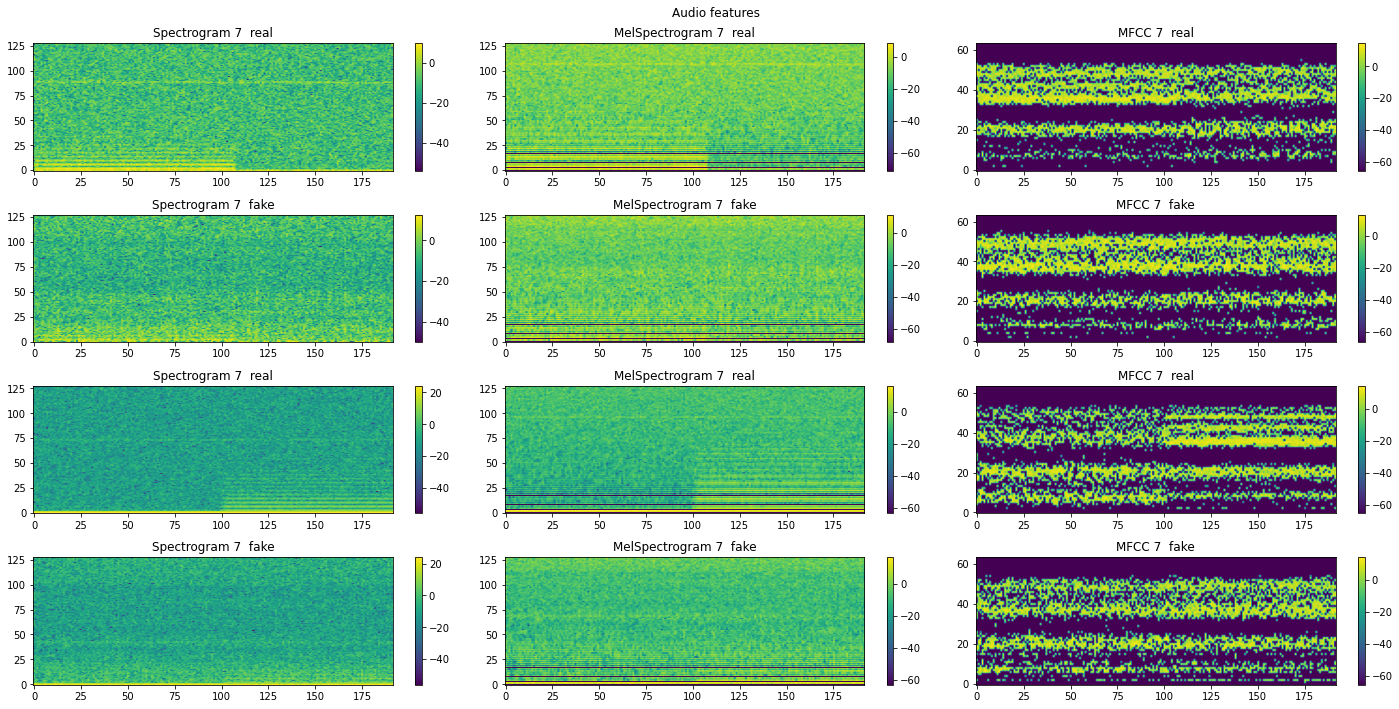

<Figure size 432x288 with 0 Axes>

In [32]:
import librosa
spec = Spectrogram(measurement_frequency=6400)
mel_spec = MelSpectrogram(measurement_frequency=6400)
mfcc = MFCC(measurement_frequency=6400)

plt.figure(figsize=(20, 10))
plt.suptitle(f'Audio features')

j = 0
k = 0
for i in range(0, 4):

    if i % 2 == 0:
        sample = x[k], v[k], c[k]
        sub = ' real'
        k += 1
    else:
        sample = generated_X[j], v[j], c[j]
        sub = ' fake'
        j += 1

    _, _, features, class_nr = spec((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+1)
    plt.imshow(librosa.power_to_db(features), origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'Spectrogram {sample[2]} {sub}')

    _, _, features, class_nr = mel_spec((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+2)
    plt.imshow(librosa.power_to_db(features), origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'MelSpectrogram {sample[2]} {sub}')

    _, _, features, class_nr = mfcc((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+3)
    plt.imshow(librosa.power_to_db(features), origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'MFCC {sample[2]} {sub}')

plt.tight_layout()
plt.show()